Index(['time in min', '(S)-3-OH-PAC', '3-OH-BA', '(R)-3-OH-PAC',
       '(S)-3-OH-PAC.1', '3-OH-BA.1', '(R)-3-OH-PAC.1'],
      dtype='object')


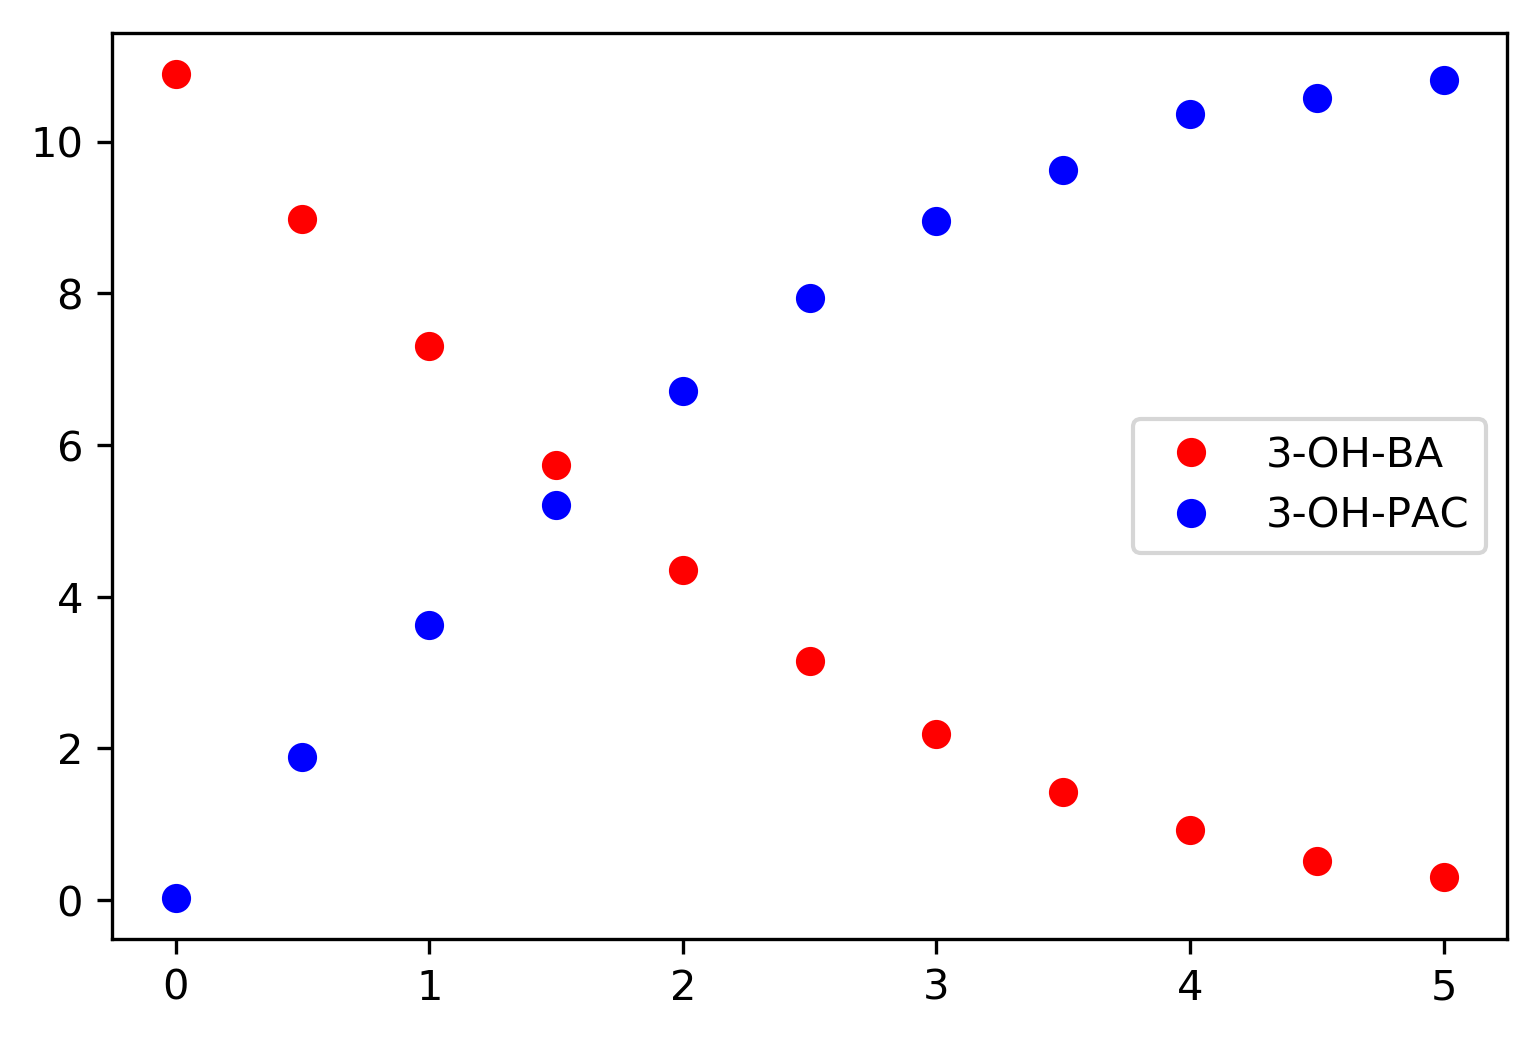

In [4]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import lmfit

df = pd.read_excel(r"Full Conversion Approach.xlsx", sheet_name = "10mL_viualisation")
plt.rcParams["figure.dpi"] = 300
#print(df.head())
print(df.columns)


time = df["time in min"]
substrate = df["3-OH-BA"]
product = df["(S)-3-OH-PAC"]

time_before_feed = time.iloc[:11]
substrate_before_feed = substrate.iloc[:11]
product_before_feed = product.iloc[:11]

fix, ax = plt.subplots()

ax.plot(time_before_feed, substrate_before_feed, label="3-OH-BA", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="3-OH-PAC", color="blue", linestyle="", marker="o")
#ax.plot(time, product2, label="octanediol measured", color="green", linestyle="", marker="o")
ax.legend()





# Model for describing the reaction velocity

$ dS =  \frac{dS}{dt} = -Ka * S + Kb * P  $

$ dP = \frac{dP}{dt} = Ka*S - Kb*P $

$ 10 = S+P $

$ S = 10-P $

$ P = 10-S $

## But we don't want to have the velocity, we want to have the concentration



[[10.89125651  8.97781629  7.30626428  5.73190936  4.34999448  3.14620345
   2.18897357  1.4283044   0.92770542  0.51440539  0.30357097]
 [ 0.03110091  1.88371882  3.63186183  5.21201965  6.71397226  7.93279586
   8.95364052  9.62457475 10.35836504 10.57652435 10.81390784]]
[11, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 22
    # variables        = 2
    chi-square         = 5.72100254
    reduced chi-square = 0.28605013
    Akaike info crit   = -25.6317647
    Bayesian info crit = -23.4496798
[[Variables]]
    kA:  0.50834051 +/- 0.03338610 (6.57%) (init = 2)
    kP:  1.3747e-10 +/- 0.10186993 (74102301001.87%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kA, kP) = -0.831
None


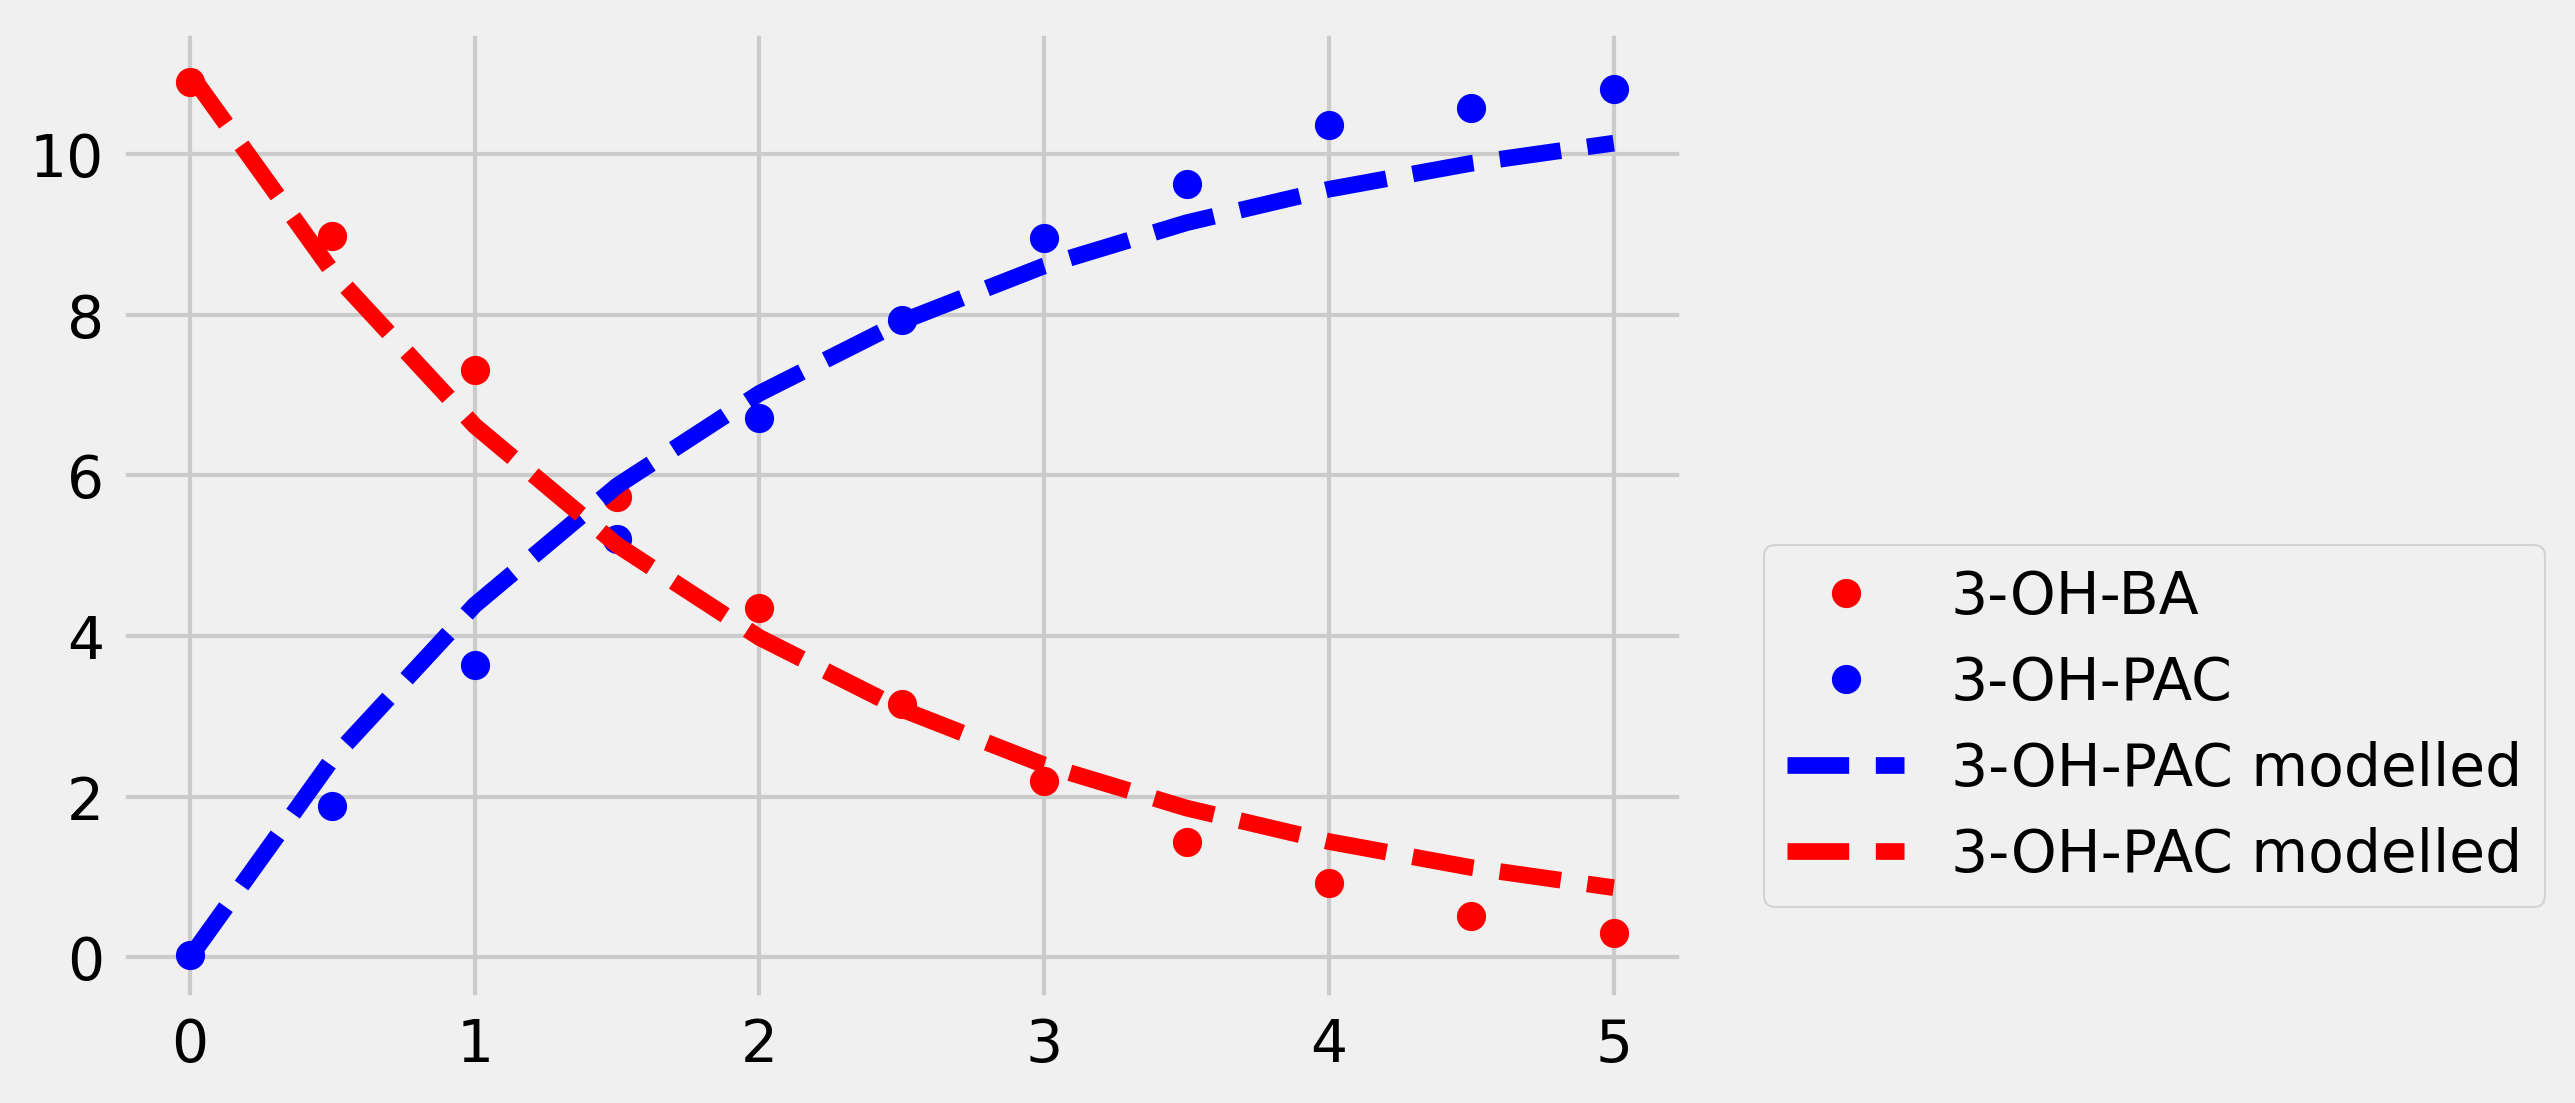

In [63]:

data_list = [substrate_before_feed,product_before_feed]

data = np.array(data_list)

print(data)


y0_array = [11, 0]
print(y0_array)


def dadt(kA, kP, A,P, t):
    dadt = -kA*A + kP*P
    return dadt

def dbdt(kA, kP, A, P, t):
        dbdt = kA*A - kP*P 
        return dbdt



def dglsys(init_cond_array, t, kA, kP):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = dadt(kA, kP, A, P, t)
    dBdt = dbdt(kA, kP, A, P,t)
    dZdt = np.array([dAdt, dBdt])
    return dZdt

    

sol = odeint(dglsys, y0_array, time_before_feed, args=(0.50834051, 0.000000000137))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)


def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    
    ymodel=odeint(dglsys, y0_array, time_before_feed, args=(kA, kP))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    result = [substr, product] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time_before_feed), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
ax.plot(time_before_feed, substrate_before_feed, label="3-OH-BA", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="3-OH-PAC", color="blue", linestyle="", marker="o")

ax.plot(time_before_feed, sol[:,1], label="3-OH-PAC modelled", linestyle="--", color="blue")
ax.plot(time_before_feed, sol[:,0], label="3-OH-PAC modelled", linestyle="--", color="red")


ax.legend(loc=9, bbox_to_anchor=(1.3,0.5))
plt.savefig("testfig.svg", format="svg")
plt.show()